### Movie recommender system with TensorFlow Recommenders

##### Abstract:
In the era of digital entertainment, personalized movie recommendation systems have emerged as a pivotal tool to enhance user engagement and satisfaction. This project delves into the realm of movie recommendation using machine learning techniques, aiming to create a sophisticated recommender system that guides users towards their ideal movie choices. The project showcases the implementation of a collaborative filtering model utilizing TensorFlow Recommenders (TFRS), capitalizing on both user and movie embeddings to predict movie ratings and furnish top-k recommendations.

##### Problem Statement:
The proliferation of digital content platforms has led to an overwhelming variety of movie options, often leaving users inundated and unsure of what to watch next. The challenge lies in deciphering user preferences and habits from past interactions, and delivering tailored movie suggestions that resonate with their tastes. Addressing this challenge, the project seeks to leverage the power of machine learning to build an effective movie recommender system. By using user-movie interaction data, the system is designed to predict movie preferences and cater to the diverse entertainment preferences of users.

##### Solution Approach:
To overcome the intricacies of movie recommendation, the project turns to TensorFlow Recommenders (TFRS), a versatile framework that amalgamates collaborative filtering with deep learning methodologies. The hybrid model is engineered to seamlessly combine user and movie embeddings, allowing it to unravel the latent patterns within the data. This integration empowers the system to generate personalized movie recommendations by estimating user preferences and suggesting movies that align with their viewing history. The project navigates through the intricacies of data preprocessing, feature engineering, and hyperparameter tuning, resulting in a refined model capable of accurately predicting movie ratings and offering a curated list of movie suggestions. Through a holistic exploration of machine learning techniques, this project demonstrates how an innovative movie recommendation system can greatly enhance the user experience, effectively catering to the diverse cinematic preferences of users.

#### Imports

import required libraries

In [1]:
from typing import Dict, Text

import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_recommenders as tfrs

#### Data pre-processing

In [2]:
# read and merge our data

ratings_df = pd.read_csv('../netflix-project/data/Netflix_Dataset_Rating.csv')
ratings_df.head()

,User_ID,Rating,Movie_ID
0,712664,5,3
1,1331154,4,3
2,2632461,3,3
3,44937,5,3
4,656399,4,3


In [3]:
movies_df = pd.read_csv('../netflix-project/data/Netflix_Dataset_Movie.csv')
movies_df.head()

,Movie_ID,Year,Name
0,1,2003,Dinosaur Planet
1,2,2004,Isle of Man TT 2004 Review
2,3,1997,Character
3,4,1994,Paula Abdul's Get Up & Dance
4,5,2004,The Rise and Fall of ECW


In [4]:
temp_movies_df = pd.read_csv('../netflix-project/data/Netflix_Dataset_Movie.csv')
ratings_df = ratings_df.merge(temp_movies_df, on='Movie_ID')

In [5]:
ratings_df.head()

,User_ID,Rating,Movie_ID,Year,Name
0,712664,5,3,1997,Character
1,1331154,4,3,1997,Character
2,2632461,3,3,1997,Character
3,44937,5,3,1997,Character
4,656399,4,3,1997,Character


In [6]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17337458 entries, 0 to 17337457
Data columns (total 5 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   User_ID   int64 
 1   Rating    int64 
 2   Movie_ID  int64 
 3   Year      int64 
 4   Name      object
dtypes: int64(4), object(1)
memory usage: 661.4+ MB


#### Exploratory Data Analysis

In this section, we'll take a closer look at our data to gain intuition about our data. Let's first take a look at the average number of ratings given by each user

In [7]:
# Group data by User_ID and calculate average number of ratings
average_ratings_count_by_user = ratings_df.groupby("User_ID")["Rating"].count().mean()

# Display the result
print(f"On average, each user has rated {int(average_ratings_count_by_user)} movies in the dataset")

On average, each user has rated 120 movies in the dataset


In [8]:
no_of_rated_products_per_users = ratings_df.groupby(by='User_ID')['Rating'].count().sort_values(ascending=False)
no_of_rated_products_per_users.head()

User_ID
305344     1344
387418     1339
2439493    1324
2118461    1305
1664010    1257
Name: Rating, dtype: int64

Let's look at some visualizations, based on what we see from our first plot, it seems like there are more recent movies in the dataset compared to older movies

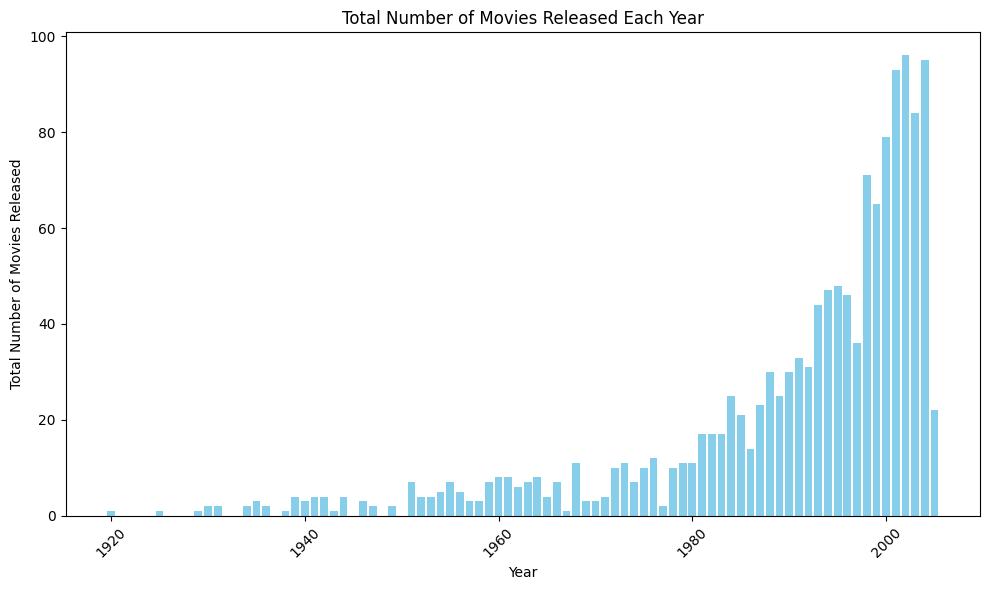

In [9]:
# Group the DataFrame by 'Year' and count the number of unique 'Name' values
yearly_movie_counts = ratings_df.groupby('Year')['Name'].nunique()

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(yearly_movie_counts.index, yearly_movie_counts.values, color='skyblue')
plt.xlabel('Year')
plt.ylabel('Total Number of Movies Released')
plt.title('Total Number of Movies Released Each Year')

# rotate the x-axis labels for better visibility if the year labels are long.
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

We can also see that more favorable ratings are given, with 34.0% of users giving a 4 star rating, compared to 10.1% for a 2 star rating

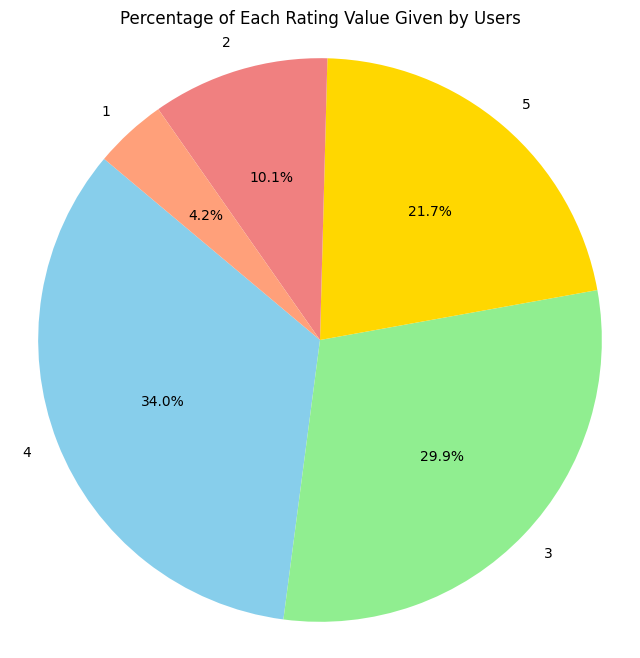

In [10]:
# Group the DataFrame by 'Rating' and count the number of occurrences
rating_counts = ratings_df['Rating'].value_counts()

# Plotting
plt.figure(figsize=(8, 8))
plt.pie(rating_counts, labels=rating_counts.index, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'lightgreen', 'gold', 'lightcoral', 'lightsalmon'])
plt.title('Percentage of Each Rating Value Given by Users')
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.

plt.show()

Visualizing our dataset on ratings of movie by release year, it seems like there's no correlation between Movies released on a certain year and favorable rating given.

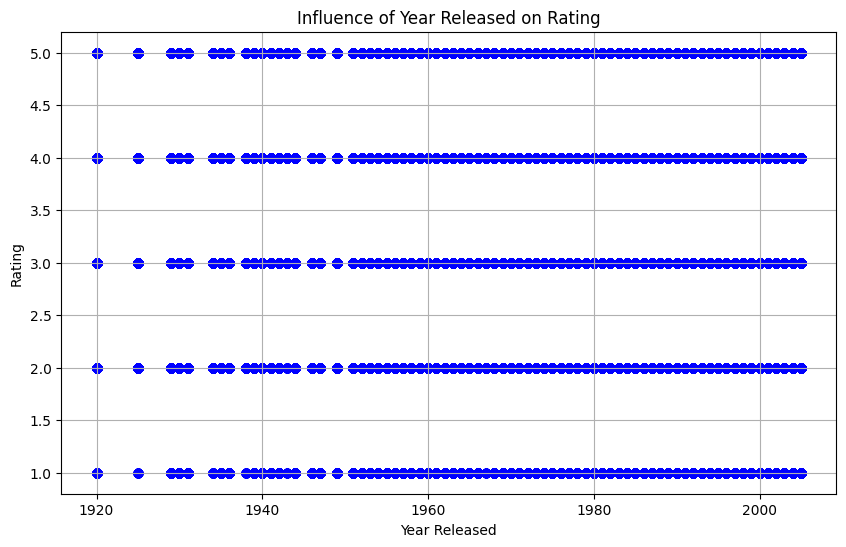

In [11]:
# Scatter Plot: Influence of Year Released on Rating
plt.figure(figsize=(10, 6))
plt.scatter(ratings_df["Year"], ratings_df["Rating"], color='blue', alpha=0.5)
plt.xlabel("Year Released")
plt.ylabel("Rating")
plt.title("Influence of Year Released on Rating")
plt.grid(True)
plt.show()

# No correlation between year released and rating given

#### Data Processing

In [12]:
# convert 'User ID' to prepare for user embedding layer in the model

ratings_df['User_ID'] = ratings_df['User_ID'].astype('str')

ratings = tf.data.Dataset.from_tensor_slices(dict(ratings_df[['User_ID', 'Rating', 'Name']]))
movies = tf.data.Dataset.from_tensor_slices(dict(movies_df[['Name']]))

In [13]:
ratings = ratings.map(lambda x: {
    "Name": x["Name"],
    "User_ID": x["User_ID"],
    "Rating": x["Rating"]
})

movies = movies.map(lambda x: x["Name"])

In [14]:
print("Total Data: {}".format(len(ratings)))

Total Data: 17337458


In [15]:
# prep for building vocabularies and splitting data into a train and test set

tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(80_000)
test = shuffled.skip(80_000).take(20_000)

movie_titles = movies.batch(1_000)
user_ids = ratings.batch(1_000_000).map(lambda x: x["User_ID"])

unique_movie_titles = np.unique(np.concatenate(list(movie_titles)))
unique_user_ids = np.unique(np.concatenate(list(user_ids)))

In [16]:
print('Unique movie titles: {}'.format(len(unique_movie_titles)))
print('Unique user ids: {}'.format(len(unique_user_ids)))

unique_movie_titles[:10]

Unique movie titles: 17297
Unique user ids: 143458


array([b"'Allo 'Allo!: Series 1", b"'Allo 'Allo!: Series 2",
       b"'Allo 'Allo!: Series 3", b"'N Sync: 'N the Mix",
       b"'N Sync: Live at Madison Square Garden",
       b"'N Sync: Making of the Tour", b"'N Sync: PopOdyssey Live",
       b"'N Sync: Unauthorized Biography", b"'Round Midnight",
       b'... And God Spoke'], dtype=object)

#### Model Implementation

<figure>
    <center> <img src="./two-tower-model.png"   style="width:500px;height:280px;" ></center>
</figure>

The focus on this model would be on two critical-parts:
* optimize for two objectives (retrieval and ranking), thus, having two losses
* share variables between tasks, allowing for transfer learning

The graph shows the architecture of the two-tower model that will be used for this project: retrieval and ranking using the dataset with ratings of movies given by the user. It is a neural network with 2 sub-models using representations for queries('User_ID') and candidates('Name') separately.

With this model, it may use representations learned from abundant task to improve its predictions on the sparse task via transfer learning.

The two-tower model will include the following:
* <b>A user-tower:</b> turns 'User_ID's into user-embeddings (high-dimensional vector representations)
* <b>A movie-tower:</b> turns movie tiles 'Name's into movie-embeddings
* <b>Task (Rating/Ranking):</b> MSE (Loss to predict ratings), RMSE (metrics)
* <b>Task (Retrieval):</b> the Retrieval task object is a wrapper that bundles together the loss function and metric computation. top-k metrics is used

<b>Top-k metrics:</b> given a user and a known watched movie, how highly would the model rank the true movie out of all possible movies?

The model architecture also shows the score of the given query-candidate pair, which is the dot product of the output of the two towers.

<b>Embedding dimension:</b> we will use an embedding size of 32, larger dimensions for embedding layer may yield more accurate result but may be prone to overfitting

<b>Call:</b> The call method define how our model computes its predictions, which uses user_embeddings, movie_embeddings as inputs and applying them to the rating model. (not to be called directly)

The <b>compute_loss</b> method describe how the model should be trained, since this is a multi-task model, loss weights will be combined in both tasks, and can be adjusted depending on the weights assigned.

The model below combines both a collaborative and content-based filtering aspect:
* <b>Collaborative Filtering:</b> By learning embeddings for both users and movies, we capture user-movie interactions. The retrieval task leverages the collaborative filtering aspect to recommend movies to users based on their embeddings.
* <b>Content-Based Filtering:</b> The model also learn embeddings for movie names, which can be seen as capturing content-related features. We can improve this model by expanding the vocabulary of the movie embeddings with additional features such as movie descriptions, etc, if available.

In [17]:
class MovieModel(tfrs.models.Model):
    def __init__(self, rating_weight: float, retrieval_weight: float) -> None:
        # we take the loss weights in the constructor: this allows us to instantiate
        # several model objects with different loss weights
        super().__init__()

        embedding_dimension = 32

        # user and movie models
        self.movie_model: tf.keras.layers.Layer = tf.keras.Sequential([
            tf.keras.layers.StringLookup(
            vocabulary=unique_movie_titles, mask_token=None
            ),
            # we add an additional embedding to account for unknown tokens
            tf.keras.layers.Embedding(len(unique_movie_titles) + 1, embedding_dimension)
        ])
        self.user_model: tf.keras.layers.Layer = tf.keras.Sequential([
            tf.keras.layers.StringLookup(
            vocabulary=unique_user_ids, mask_token=None),
            tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
        ])

        # A small model to take in user and movie embeddings and predict ratings
        # we can make this as complicated as we want as long as we output a scalar
        # as our prediction
        self.rating_model = tf.keras.Sequential([
            tf.keras.layers.Dense(256, activation="relu"),
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.Dense(1)
        ])

        # the tasks
        self.rating_task: tf.keras.layer.Layer = tfrs.tasks.Ranking(
            loss=tf.keras.losses.MeanSquaredError(),
            metrics=[tf.keras.metrics.RootMeanSquaredError()]
        )
        self.retrieval_task: tf.keras.layers.Layer = tfrs.tasks.Retrieval(
            metrics=tfrs.metrics.FactorizedTopK(
            candidates=movies.batch(128).map(self.movie_model)
            )
        )

        # The loss weights
        self.rating_weight = rating_weight
        self.retrieval_weight = retrieval_weight

    def call(self, features: Dict[Text, tf.Tensor]) -> tf.Tensor:
        # we pick out the user features and pass them into the user model
        user_embeddings = self.user_model(features["User_ID"])
        # and pick out the movie features and pass them into the movie model
        movie_embeddings = self.movie_model(features["Name"])

        return(
            user_embeddings,
            movie_embeddings,
            # we apply the multi-layered rating model to a concatenation of 
            # user and movie embeddings
            self.rating_model(
            tf.concat([user_embeddings, movie_embeddings], axis=1)
            )
        )
    
    def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
        ratings = features.pop("Rating")
        user_embeddings, movie_embeddings, rating_predictions = self(features)

        # we compute the loss for each task
        rating_loss = self.rating_task(
            labels=ratings,
            predictions=rating_predictions
        )
        retrieval_loss = self.retrieval_task(user_embeddings, movie_embeddings)

        # and combine them using the loss weights
        return (self.rating_weight * rating_loss
                + self.retrieval_weight * retrieval_loss)

#### Fitting and Evaluating

In [18]:
# instantiate the model

model = MovieModel(rating_weight=0.9, retrieval_weight=1.0)
model.compile(optimizer=tf.keras.optimizers.legacy.Adagrad(0.1))

In [19]:
# shuffle, batch, and cache the training and evaluation data

cached_train = train.shuffle(100_000).batch(8_192).cache()
cached_test = test.batch(4_096).cache()

##### Model Metrics Interpretation
In this model, we will receive two metrics to evaluate the performance of our model for both tasks:

* Retrieval Top-100 categorical accuracy: the number of movies generated that the model has accurately predicted out of the top 100 movies generated. Higher number usually equates to better model performance.
* Ranking RMSE: we want our error value to be as low as possible.

The rating and retrieval weights of our model may be tweaked to compare which weight distribution yield better results.

In [21]:
# train the model

model.fit(cached_train, epochs=3)
metrics = model.evaluate(cached_test, return_dict=True)

print(f"Retrieval top-100 accuracy: {metrics['factorized_top_k/top_100_categorical_accuracy']:.3f}")
print(f"Ranking RMSE: {metrics['root_mean_squared_error']:.3f}")

Epoch 1/3
10/10 [==============================] - 17s 2s/step - root_mean_squared_error: 1.0572 - factorized_top_k/top_1_categorical_accuracy: 0.4922 - factorized_top_k/top_5_categorical_accuracy: 0.8820 - factorized_top_k/top_10_categorical_accuracy: 0.8995 - factorized_top_k/top_50_categorical_accuracy: 0.9116 - factorized_top_k/top_100_categorical_accuracy: 0.9124 - loss: 64311.4865 - regularization_loss: 0.0000e+00 - total_loss: 64311.4865
Epoch 2/3
10/10 [==============================] - 16s 2s/step - root_mean_squared_error: 1.1015 - factorized_top_k/top_1_categorical_accuracy: 0.5206 - factorized_top_k/top_5_categorical_accuracy: 0.8964 - factorized_top_k/top_10_categorical_accuracy: 0.9255 - factorized_top_k/top_50_categorical_accuracy: 0.9455 - factorized_top_k/top_100_categorical_accuracy: 0.9469 - loss: 62120.4581 - regularization_loss: 0.0000e+00 - total_loss: 62120.4581
Epoch 3/3
5/5 [==============================] - 4s 815ms/step - root_mean_squared_error: 1.0529 - fac

#### Making predictions

'tfrs.layers.factorized_top_k.BruteForce' layer will be used to make predictions.
The BruteForce layer may be slower when serving a model with many possible candidates, in which other layer may be used to speed this up, such as the 'TFRS ScaNN' layer

In [22]:
def predict_movie(user, top_n=5):
    # create a model that takes in raw query ft user
    index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)

    # recommends movies out of the entire movies dataset
    index.index_from_dataset(
        tf.data.Dataset.zip((movies.batch(100), movies.batch(100).map(model.movie_model)))
    )

    # get recommendations
    _, titles = index(tf.constant([str(user)]))

    print('Top {} recommendations for user {}:\n'.format(top_n, user))
    
    unique_titles = set()  # To store unique titles
    
    for i, title in enumerate(titles[0].numpy()):
        title_str = title.decode("utf-8")
        if title_str not in unique_titles:
            unique_titles.add(title_str)
            print('{}. {}'.format(len(unique_titles), title_str))
            
            if len(unique_titles) == top_n:
                break

def predict_rating(user, movie):
    trained_movie_embeddings, trained_user_embeddings, predicted_rating = model({
        "User_ID": np.array([str(user)]),
        "Name": np.array([movie])
    })
    print("Predicted rating for {}: {}".format(movie, predicted_rating))

#### Results

let's try our model by making some predictions on a random user from our test dataset. Let's also make sure that our random user does not exist in our training dataset.

In [23]:
# Convert the CacheDataset to an iterator
cached_test_iter = iter(cached_test)

# Get the number of batches in the dataset
num_batches = len(cached_test)

# Choose a random batch index
random_batch_index = random.randint(0, num_batches - 1)

# Create a separate random number generator for this code snippet
user_id_random_generator = random.Random(1)

# Iterate to the random batch
for i in range(random_batch_index + 1):
    element = next(cached_test_iter)

# Choose a random index within the batch using the separate random generator
random_index_in_batch = user_id_random_generator.randint(0, len(element['User_ID']) - 1)

# Get the random 'User_ID'
random_user_id = element['User_ID'][random_index_in_batch].numpy()

print("Randomly selected 'User_ID':", random_user_id.decode("utf-8"))

Randomly selected 'User_ID': 1904227


Running the code above will select a random user from our test dataset, and running it again may randomly select a different user. To ensure that our random user that was previously selected from the test set was not in the training set, we will run the following code

Let's check to make sure 'User_ID': 169999 does not exist in the training dataset

In [24]:
# Convert the CacheDataset to an iterator
cached_train_iter = iter(cached_train)

# Check if 'User_ID' '169999' exists in the dataset
user_id_to_find = b'169999'
user_id_found = False

for _ in range(len(cached_train)):  # Loop through all batches in the cached_train
    element = next(cached_train_iter)
    user_ids = element['User_ID']
    
    if user_id_to_find in user_ids:
        user_id_found = True
        break

if user_id_found:
    print(f"User with 'User_ID' {user_id_to_find} exists in the cached_train dataset.")
else:
    print(f"User with 'User_ID' {user_id_to_find} does not exist in the cached_train dataset.")

User with 'User_ID' b'169999' does not exist in the cached_train dataset.


Let's take look at what movies we should recommend to our random user '169999', for this example I have set the rating_weight = 0.9, with ranking_weight = 1.0:

In [25]:
# retrieve top 10 movies to recommend to user '169999':
predict_movie(169999, 10)

Top 10 recommendations for user 169999:

1. Character
2. Immortal Beloved
3. Aqua Teen Hunger Force: Vol. 1
4. The Love Letter
5. Carandiru
6. Never Die Alone
7. Rudolph the Red-Nosed Reindeer
8. ABC Primetime: Mel Gibson's The Passion of the Christ
9. Spitfire Grill


In [26]:
predict_rating(169999, b"Pride and Prejudice=")

Predicted rating for b'Pride and Prejudice=': [[3.2286658]]


In [27]:
# let's look at what user 169999 rating history
# to see if they would enjoy the top 10 movie recommendations
filtered_df = ratings_df[ratings_df['User_ID'] == '169999']

# Display only the first 20 rows
filtered_df.head(20)

,User_ID,Rating,Movie_ID,Year,Name
49979,169999,3,28,2002,Lilo and Stitch
108463,169999,5,30,2003,Something's Gotta Give
187719,169999,3,58,1996,Dragonheart
559965,169999,5,191,2003,X2: X-Men United
899753,169999,5,273,2004,Taxi
1036234,169999,5,299,2001,Bridget Jones's Diary
1188597,169999,5,313,2000,Pay It Forward
1323587,169999,4,331,1997,Chasing Amy
1355086,169999,4,334,2005,The Pacifier
1475628,169999,5,361,2004,The Phantom of the Opera: Special Edition


#### Result Interpretation:
When looking at the results with the assigned weights, we can see that some of the recommendations has appeared in his/her previous watch, such as Lilo and Stitch, and this may be a good thing, as the recommendation included familiar movies but also movies the user has never viewed before.


When used to predict rating, it may be a little inaccurate as Pride and Prejudice predicted rating for this user is 2.7, but the user actually rated the movie 5.0. (the user's actual rating for Pride and Prejudice is not included in the data shown here, but it's included when you show more than 20 rows of the data, the data shown here has been truncated)


This is expected as we have set the rating_weight less, increasing weight of the rating may produce better rating prediction.


This may not be entirely necessary as most users would be more interested in getting recommendation of movies they would actually want to watch, as opposed to how good the recommender is at to predicting the rating the user will give to a particular movie.

#### Final Thoughts

Given the result, Here's a few improvements we can implement to improve the test result:
* <b>Add additional Features to the dataset:</b> expand the dataset to include additional features that could provide valuable information for recommendations. For movies, we could consider adding genres, actors, directors, or movie descriptions. For users, we may include demographic information, preferences, and historical interactions: such as, watch time, time most active, etc.

* <b>Regularization, Hyperparameters and Parameters Tuning:</b> Experiment with different regularization techniques and hyperparameters settings to optimize model performance while considering bias/variance tradeoff

* <b>Explore different Models:</b> explore different models that combine the prediction of multiple models, or combine different techniques, such as matrix factorization and reinforcement learning.